In [1]:
import math
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from utils import calc_next_event, clean_df, create_train_test_data, eval_model

In [2]:
WANDB_MODE="offline"

In [3]:
wandb.login()

wandb: Currently logged in as: theyorubayesian (use `wandb login --relogin` to force relogin)


True

In [2]:
INITIAL_RUN = False
if INITIAL_RUN:
    run = wandb.init(project="next-event-prediction", reinit=True, mode=WANDB_MODE)

In [3]:
data = pd.read_csv("data/events.csv")

In [4]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2020-09-24 11:57:06 UTC,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT
1,2020-09-24 11:57:26 UTC,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY
2,2020-09-24 11:57:27 UTC,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy
3,2020-09-24 11:57:33 UTC,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08
4,2020-09-24 11:57:36 UTC,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ


In [5]:
clean_data = clean_df(data)

In [7]:
clean_data.isna().sum()

event_time                   0
event_type                   0
product_id                   0
category_id                  0
category_code           236172
brand                   212326
price                        0
user_id                      0
user_session                 0
month                        0
day                          0
hour                         0
category_code__clean         0
dtype: int64

In [8]:
session_list = clean_data.groupby("user_session")
next_events = calc_next_event(session_list=session_list)

In [9]:
clean_data = clean_data.join(next_events)

In [10]:
clean_data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,hour,category_code__clean,next_event
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT,9,24,11,electronics,exit
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,9,24,11,computers,view
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy,9,24,11,missing,exit
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,9,24,11,computers,exit
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,9,24,11,missing,exit


In [10]:
clean_data.isna().sum()

event_time                   0
event_type                   0
product_id                   0
category_id                  0
category_code           236172
brand                   212326
price                        0
user_id                      0
user_session                 0
month                        0
day                          0
hour                         0
category_code__clean         0
next_event                   0
dtype: int64

In [11]:
clean_data["next_event"].value_counts()

exit        490398
view        305730
cart         53977
purchase     34859
Name: next_event, dtype: int64

In [12]:
clean_data["purchase"] = (clean_data["next_event"] == "purchase").astype(int)

In [13]:
clean_data["purchase"].value_counts()

0    850105
1     34859
Name: purchase, dtype: int64

In [14]:
dropped_columns = [
    "brand", "product_id", "category_id", 
    "category_code", "user_id", "user_session",
    "next_event", "event_time", "month"
]

In [16]:
train, test = create_train_test_data(clean_data, return_df=True, write_df=False)

In [16]:
# NOTE: Set to true if changes are made upstream
LOG_DATA = False
if LOG_DATA:
    run.log_artifact("data/train.csv", "train-data", type="dataset")
    run.log_artifact("data/test.csv", "test-data", type="dataset")

In [16]:
train.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,month,day,hour,category_code__clean,next_event,purchase
0,2020-09-24 11:57:06+00:00,view,1996170,2144415922528452715,electronics.telephone,NaN,31.90,1515915625519388267,LJuJVLEjPT,9,24,11,electronics,exit,0
1,2020-09-24 11:57:26+00:00,view,139905,2144415926932472027,computers.components.cooler,zalman,17.16,1515915625519380411,tdicluNnRY,9,24,11,computers,view,0
2,2020-09-24 11:57:27+00:00,view,215454,2144415927158964449,NaN,NaN,9.81,1515915625513238515,4TMArHtXQy,9,24,11,missing,exit,0
3,2020-09-24 11:57:33+00:00,view,635807,2144415923107266682,computers.peripherals.printer,pantum,113.81,1515915625519014356,aGFYrNgC08,9,24,11,computers,exit,0
4,2020-09-24 11:57:36+00:00,view,3658723,2144415921169498184,NaN,cameronsino,15.87,1515915625510743344,aa4mmk0kwQ,9,24,11,missing,exit,0


In [112]:
train.brand.isna().sum()

169685

In [108]:
train["category_code__clean"].value_counts()

computers       237514
missing         191454
electronics     139473
stationery       35397
appliances       33964
auto             29051
construction     25284
furniture         2888
country_yard      2392
accessories       1750
medicine           576
kids               321
jewelry            243
sport              193
apparel             99
Name: category_code__clean, dtype: int64

In [75]:
train.groupby("category_code__clean")["brand"].nunique().sort_values(ascending=False)

category_code__clean
missing         642
computers       290
electronics     289
appliances      134
construction     96
auto             81
stationery       57
accessories      37
country_yard     18
kids              8
furniture         7
sport             4
jewelry           3
medicine          3
apparel           1
Name: brand, dtype: int64

In [10]:
train["purchase"].value_counts() # normalize=True

0    673534
1     27065
Name: purchase, dtype: int64

In [42]:
673534 / 27065

24.885793460188435

In [11]:
test["purchase"].value_counts()

0    81780
1      138
Name: purchase, dtype: int64

In [43]:
81780 / 138

592.6086956521739

In [17]:
X_train_all = train.drop(dropped_columns, axis=1)
y_train_all = X_train_all.pop("purchase")

X_test = test.drop(dropped_columns, axis=1)
y_test = X_test.pop("purchase")

In [18]:
TEST_SIZE = 0.3
# run.log({"testsize": TEST_SIZE})

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=TEST_SIZE, shuffle=False)

In [20]:
X_val.head()

,event_type,price,day,hour,category_code__clean
490553,view,19.94,23,10,missing
490554,purchase,98.25,23,10,missing
490555,view,23.57,23,10,missing
490556,view,418.48,23,10,computers
490557,view,18.57,23,10,computers


In [21]:
categorical_cols = ["event_type", "category_code__clean"]
numerical_cols = ["price", "day", "hour"]

(array([1.09000e+02, 3.13500e+03, 1.01130e+04, 1.60737e+05, 1.72938e+05,
        1.17891e+05, 2.40560e+04, 1.37700e+03, 5.00000e+01, 1.30000e+01]),
 array([-0.65757732, -0.11068149,  0.43621435,  0.98311018,  1.53000601,
         2.07690184,  2.62379768,  3.17069351,  3.71758934,  4.26448517,
         4.811381  ]),
 <BarContainer object of 10 artists>)

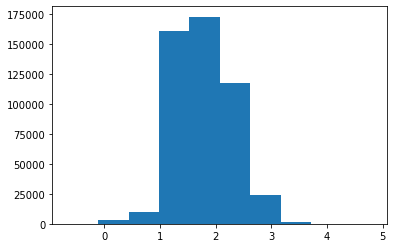

In [22]:
plt.hist(X_train["price"].apply(np.log10))

In [23]:
preprocessor = ColumnTransformer(
    [
        ("price_transformer", FunctionTransformer(np.log10), ["price"]),
        ("categorical_transformer", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("time_transformer", MinMaxScaler(), ["hour", "day"])
    ], remainder="drop"
)

### Logistic Regression

In [24]:
run = wandb.init(project="next-event-prediction", group="logistic-regression", reinit=True, mode=WANDB_MODE)

In [25]:
MAX_ITERATION=1000
run.log({"max-iteration": MAX_ITERATION})

In [26]:
lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(class_weight="balanced", max_iter=MAX_ITERATION)) # 
    ]
)

In [27]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('price_transformer',
                                                  FunctionTransformer(func=<ufunc 'log10'>),
                                                  ['price']),
                                                 ('categorical_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_type',
                                                   'category_code__clean']),
                                                 ('time_transformer',
                                                  MinMaxScaler(),
                                                  ['hour', 'day'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

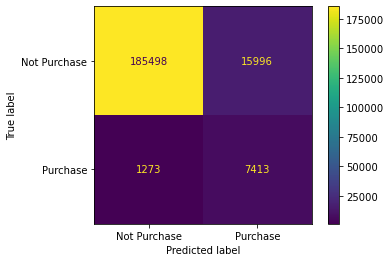

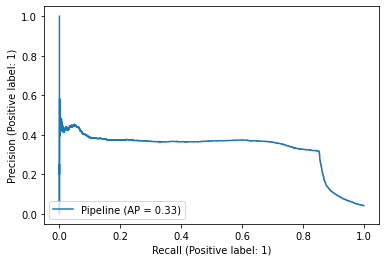

In [28]:
eval_results__lr = eval_model(lr_pipeline, X_val, y_val, return_preds=True, include_plots=True, mode="eval")
eval_cmatrix__lr = eval_results__lr.pop("eval_confusion_matrix")
eval_pr_curve__lr = eval_results__lr.pop("eval_precision_recall_curve")
eval_pred__lr = eval_results__lr.pop("eval_y_pred")

In [29]:
run.log(eval_results__lr)
pprint(eval_results__lr)

{'_runtime': 138,
 '_timestamp': 1648212732,
 'eval_accuracy': 0.9178370920163669,
 'eval_f1': 0.7087318789692719,
 'eval_precision': 0.6549286205826822,
 'eval_recall': 0.8870276708556962}


In [31]:
y_val.value_counts()

0    201494
1      8686
Name: purchase, dtype: int64

In [1]:
201494/8686

23.1975592908128

In [36]:
np.unique(eval_pred__lr, return_counts=True)

(array([0, 1]), array([186771,  23409]))

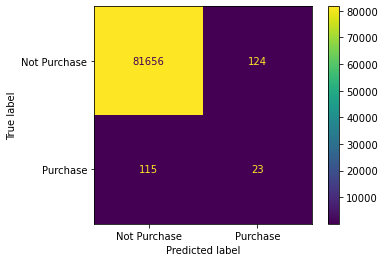

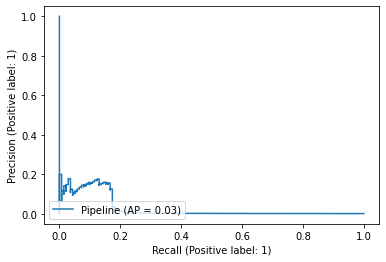

In [30]:
test_results__lr = eval_model(lr_pipeline, X_test, y_test, return_preds=True, include_plots=True, mode="test")
test_cmatrix__lr = test_results__lr.pop("test_confusion_matrix")
test_pr_curve__lr = test_results__lr.pop("test_precision_recall_curve")
test_pred__lr = test_results__lr.pop("test_y_pred")

In [31]:
run.log(test_results__lr)
pprint(test_results__lr)

{'_runtime': 65,
 '_timestamp': 1647966501,
 'test_accuracy': 0.9970824483019605,
 'test_f1': 0.5799710954477744,
 'test_precision': 0.5775281092368708,
 'test_recall': 0.5825752017608218}


In [28]:
y_test.value_counts()

0    81780
1      138
Name: purchase, dtype: int64

In [32]:
np.unique(test_pred__lr, return_counts=True)

(array([0, 1]), array([81771,   147]))

In [33]:
run.finish()

max-iteration,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
max-iteration,10000
test_accuracy,0.99708
test_f1,0.57997
test_precision,0.57753
test_recall,0.58258


### Decision Tree

In [31]:
run = wandb.init(project="next-event-prediction", group="decision-tree", reinit=True, mode=WANDB_MODE)

eval_accuracy,▁
eval_f1,▁
eval_precision,▁
eval_recall,▁
max-iteration,▁
eval_accuracy,0.91784
eval_f1,0.70873
eval_precision,0.65493
eval_recall,0.88703
max-iteration,1000


In [25]:
run.log({"model_type": "decision-tree"})

In [26]:
dt_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(class_weight="balanced")) # 
    ]
)

In [ ]:
dt_pipeline_imb = ImbPipeline(
    [
        ("preprocessor", preprocessor),
        # ("sampler", RandomUnderSampler(sampling_strategy="majority")),
        ("sampler", SMOTEENN(sampling_strategy="all", n_jobs=-1)),
        ("model", DecisionTreeClassifier(class_weight="balanced"))
    ]
)

In [27]:
dt_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('price_transformer',
                                                  FunctionTransformer(func=<ufunc 'log10'>),
                                                  ['price']),
                                                 ('categorical_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['event_type',
                                                   'category_code__clean']),
                                                 ('time_transformer',
                                                  MinMaxScaler(),
                                                  ['hour', 'day'])])),
                ('model', DecisionTreeClassifier(class_weight='balanced'))])

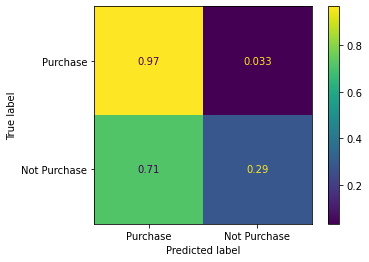

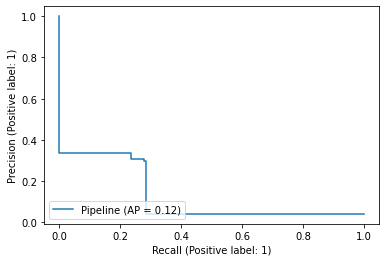

In [48]:
eval_results__dt = eval_model(dt_pipeline, X_val, y_val, return_preds=True, include_plots=True, mode="eval")
eval_cmatrix__dt = eval_results__dt.pop("eval_confusion_matrix")
eval_pr_curve__dt = eval_results__dt.pop("eval_precision_recall_curve")
eval_pred__dt = eval_results__dt.pop("eval_y_pred")

In [50]:
run.log(eval_results__dt)
pprint(eval_results__dt)

{'_runtime': 585,
 '_timestamp': 1647734501,
 'eval_accuracy': 0.9385526691407365,
 'eval_f1': 0.6225357468309939,
 'eval_precision': 0.6193958608945247,
 'eval_recall': 0.6258899937567681}


In [49]:
np.unique(eval_pred__dt, return_counts=True)

(array([0, 1]), array([200999,   9181]))

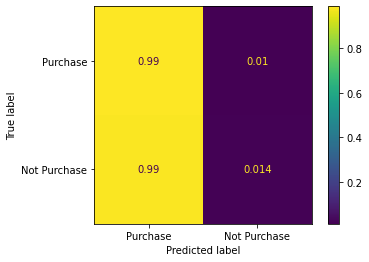

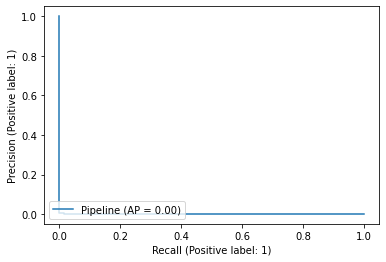

In [51]:
test_results__dt = eval_model(dt_pipeline, X_test, y_test, return_preds=True, include_plots=True, mode="test")
test_cmatrix__dt = test_results__dt.pop("test_confusion_matrix")
test_pr_curve__dt = test_results__dt.pop("test_precision_recall_curve")
test_pred__dt = test_results__dt.pop("test_y_pred")

In [52]:
run.log(test_results__dt)
pprint(test_results__dt)

{'_runtime': 683,
 '_timestamp': 1647734599,
 'test_accuracy': 0.9881222686100735,
 'test_f1': 0.4990598362701966,
 'test_precision': 0.5003532069202331,
 'test_recall': 0.5021289886971408}


In [55]:
np.unique(test_pred__dt, return_counts=True)

(array([0, 1]), array([81079,   839]))

In [54]:
run.finish()

eval_accuracy,▁
eval_f1,▁
eval_precision,▁
eval_recall,▁
test_accuracy,▁
test_f1,▁
test_precision,▁
test_recall,▁
eval_accuracy,0.93855
eval_f1,0.62254
eval_precision,0.6194


### Threshold Moving

In [17]:
y_pred_probs = lr_pipeline.predict_proba(X_test)

In [29]:
min(y_pred_probs[:, 1])

0.0361251642381288

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs[:, 1])

In [24]:
min(thresholds)

0.0361251642381288

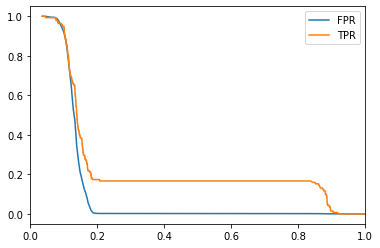

In [44]:
plt.plot(thresholds, fpr, label="FPR")
plt.plot(thresholds, tpr, label="TPR")
plt.xlim(0.0, 1.0)
plt.legend()
plt.show()

In [65]:
y_pred__tt = np.where(y_pred_probs[:, 1] >= 0.20, 1, 0)

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

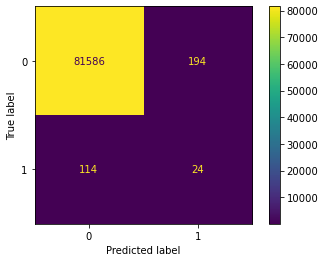

In [66]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred__tt)

In [54]:
precision_recall_fscore_support(y_test, y_pred__tt, average="macro")

(0.5009246157208217, 0.5896323115038226, 0.44583362650508446, None)

/var/folders/1m/w328y2ls09g_d3dgbmpq25yh0000gn/T/ipykernel_7721/1359687571.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


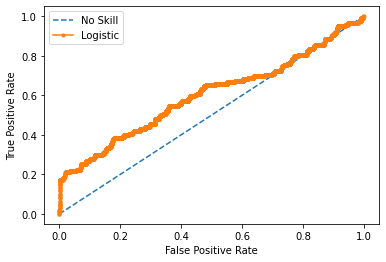

In [24]:
fig, ax = plt.subplots()

ax.plot([0,1], [0,1], linestyle='--', label='No Skill')
ax.plot(fpr, tpr, marker='.', label='Logistic')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
fig.show()

In [ ]:
new_categories = {}
for brand in train.query("category_code__clean == 'missing'")["brand"].unique():
    categories = train.query("brand == @brand")["category_code__clean"].value_counts()
    # print(type(brand))
    if not isinstance(brand, str) and math.isnan(brand):
        new_categories[brand] = "missing"
    elif len(categories) == 1:
        new_categories[brand] = categories.index[0]
    elif categories.index[0] == 'missing':
        new_categories[brand] = categories.index[1]

In [ ]:
np.unique(new_categories, return_counts=True)